In [132]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
from multiprocessing.pool import ThreadPool
from shapely.geometry import Polygon, MultiPolygon, shape

In [133]:
SAMPLE_FREQ = 3

In [134]:
plt.rcParams['figure.figsize'] = [10, 5]

In [135]:
import seaborn as sns
sns.set_theme()

In [136]:
ACLED_SPREADSHEET = 'Ukraine_Black_Sea_2020_2023_Mar10.xlsx'
ACLED_CSV = 'Ukraine_Black_Sea_2020_2023_Mar10.csv'

In [137]:
acled = pd.read_excel(ACLED_SPREADSHEET)

In [138]:
acled.columns

Index(['ISO', 'EVENT_ID_CNTY', 'EVENT_ID_NO_CNTY', 'EVENT_DATE', 'YEAR',
       'TIME_PRECISION', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1',
       'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2', 'ASSOC_ACTOR_2', 'INTER2',
       'INTERACTION', 'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'ADMIN3',
       'LOCATION', 'LATITUDE', 'LONGITUDE', 'GEO_PRECISION', 'SOURCE',
       'SOURCE_SCALE', 'NOTES', 'FATALITIES', 'TIMESTAMP'],
      dtype='object')

In [139]:
acled.ACTOR1.unique()

array(['Police Forces of Romania (2016-2019) Coast Guard',
       'Military Forces of Romania (2021-)', 'Protesters (Romania)',
       'Unidentified Military Forces',
       'Military Forces of Turkey (2016-)',
       'Military Forces of Ukraine (2014-2019)',
       'NAF: United Armed Forces of Novorossiya', 'Protesters (Ukraine)',
       'Unidentified Armed Group (Ukraine)', 'Rioters (Ukraine)',
       'Military Forces of Russia (2000-)',
       'Police Forces of Ukraine (2014-2019) Security Service of Ukraine',
       "Donetsk People's Republic - Government",
       'Private Security Forces (Russia)', 'Right Sector',
       'Government of Ukraine (2014-2019)',
       'Military Forces of Ukraine (2014-2019) National Guard',
       'Police Forces of Russia (2000-)',
       'Military Forces of Canada (2015-)', 'National Militia',
       'Protesters (Russia)', 'ONR: National Radical Camp',
       'Military Forces of Russia (2000-) National Guard',
       'National Corps Party', 'Police F

In [140]:
acled.ACTOR1.value_counts().head(30)

Military Forces of Russia (2000-)                                      31637
NAF: United Armed Forces of Novorossiya                                20543
Military Forces of Ukraine (2019-)                                     19977
Military Forces of Ukraine (2014-2019)                                 12230
Protesters (Ukraine)                                                    5533
Military Forces of Russia (2000-) Air Force                             2224
Unidentified Armed Group (Ukraine)                                      1009
Rioters (Ukraine)                                                        418
Civilians (Ukraine)                                                      333
Military Forces of Ukraine (2019-) Air Force                             202
Unidentified Military Forces                                             181
Police Forces of Ukraine (2019-) State Emergency Service of Ukraine       89
Police Forces of Ukraine (2014-2019)                                      79

In [141]:
acled['date'] = pd.to_datetime(acled.EVENT_DATE)

In [142]:
acled = acled.set_index('date')

In [143]:
war = acled['2022-02-24':]

In [144]:
war.ACTOR1.value_counts().head(40)

Military Forces of Russia (2000-)                                        31604
Military Forces of Ukraine (2019-)                                        7802
Military Forces of Russia (2000-) Air Force                               2224
Civilians (Ukraine)                                                        332
NAF: United Armed Forces of Novorossiya                                    279
Military Forces of Ukraine (2019-) Air Force                               202
Unidentified Military Forces                                               181
Protesters (Ukraine)                                                       166
Police Forces of Ukraine (2019-) State Emergency Service of Ukraine         88
Wagner Group                                                                46
Unidentified Armed Group (Ukraine)                                          42
Melitopol Communal Militia (Ukraine)                                        39
Government of Ukraine (2019-)                       

In [145]:
not_ukraine = war[~war['ACTOR1'].str.contains('Ukraine')]

In [146]:
not_ukraine.ACTOR1.value_counts().head(40)

Military Forces of Russia (2000-)                                        31604
Military Forces of Russia (2000-) Air Force                               2224
NAF: United Armed Forces of Novorossiya                                    279
Unidentified Military Forces                                               181
Wagner Group                                                                46
Military Forces of Russia (2000-) Navy                                      25
Luhansk People's Republic - Police                                          13
Military Forces of Russia (2000-) Chechen Battalion of Ramzan Kadyrov        9
Military Forces of Russia (2000-) Donetsk People's Militia                   6
Government of Russia (2000-)                                                 5
Military Forces of Romania (2021-)                                           4
Military Forces of Turkey (2016-)                                            4
Police Forces of Russia (2000-)                     

In [147]:
not_ukraine.EVENT_TYPE.value_counts().head(40)

Explosions/Remote violence    27619
Battles                        5691
Violence against civilians      705
Strategic developments          396
Protests                          6
Name: EVENT_TYPE, dtype: int64

In [148]:
not_russia.SUB_EVENT_TYPE.value_counts().head(40)

Shelling/artillery/missile attack      25060
Armed clash                             5437
Air/drone strike                        2234
Attack                                   369
Remote explosive/landmine/IED            321
Abduction/forced disappearance           312
Non-state actor overtakes territory      254
Disrupted weapons use                    168
Looting/property destruction             145
Change to group/activity                  51
Sexual violence                           24
Other                                     22
Peaceful protest                           6
Arrests                                    4
Non-violent transfer of territory          4
Grenade                                    3
Headquarters or base established           1
Suicide bomb                               1
Agreement                                  1
Name: SUB_EVENT_TYPE, dtype: int64

In [149]:
strikes = not_ukraine[not_ukraine.SUB_EVENT_TYPE == 'Air/drone strike']

In [150]:
strikes.NOTES.values

array(['On 24 February 2022, a Russian airstrike targeted the Mikolaiv air base, Mykolaivka, Mikolaiv oblast, creating a large crater outside the base. Casualties unknown.',
       'On 24 February 2022, Russian airstrikes hit Ukrainka, Kyiv oblast. Target unknown. Casualties unknown.',
       'On 24 February 2022, a Russian air force missile hit the Turkish-owned bulk carrier vessel Yasa Jupiter off the Coast of Odesa, 50nm south of the city, after it had unloaded cargo in Ukraine. The vessel sustained damage but managed to divert to Romanian territorial waters. No fatalities.',
       ...,
       "On 9 March 2023, Russian military forces fired air-launched 'Kinzhal' missiles and kamikaze-drones at Kyiv - Holosiivskyi, Kyiv City, damaging an object of critical infrastructure. Casualties unknown.",
       'On 9 March 2023, Russian missiles and kamikaze-drones struck an object of critical infrastructure and residential buildings in the Odesa region (coded to Odesa, Odesa). There were no 

In [151]:
strikes['dummy'] = 1

/tmp/ipykernel_82737/307377284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikes['dummy'] = 1


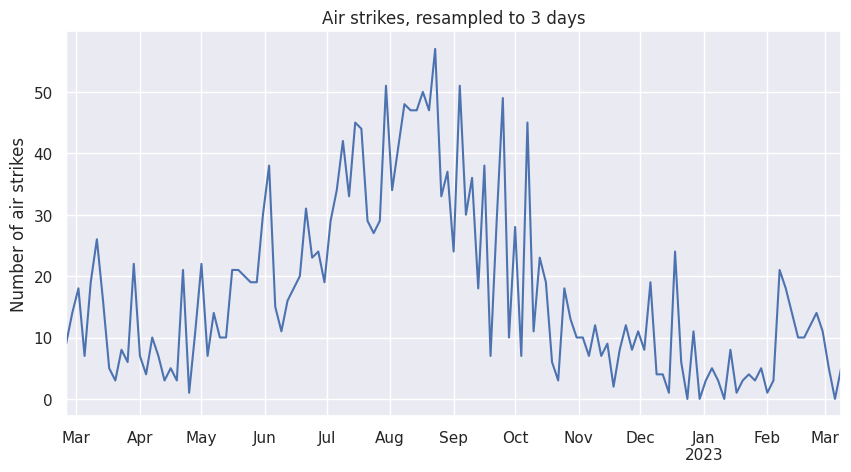

In [152]:
plt.figure()
plt.title(f'Air strikes, resampled to {SAMPLE_FREQ} days')
strikes['dummy'].resample('3d').sum().plot(xlabel='', ylabel='Number of air strikes')
plt.savefig('acled_air_strikes.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_air_strikes.png', bbox_inches='tight', dpi=600)

In [153]:
missiles = strikes[strikes['NOTES'].str.contains('missile|rocket')]

In [154]:
missiles['dummy'] = 1

/tmp/ipykernel_82737/2671073949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missiles['dummy'] = 1


<AxesSubplot: xlabel='date'>

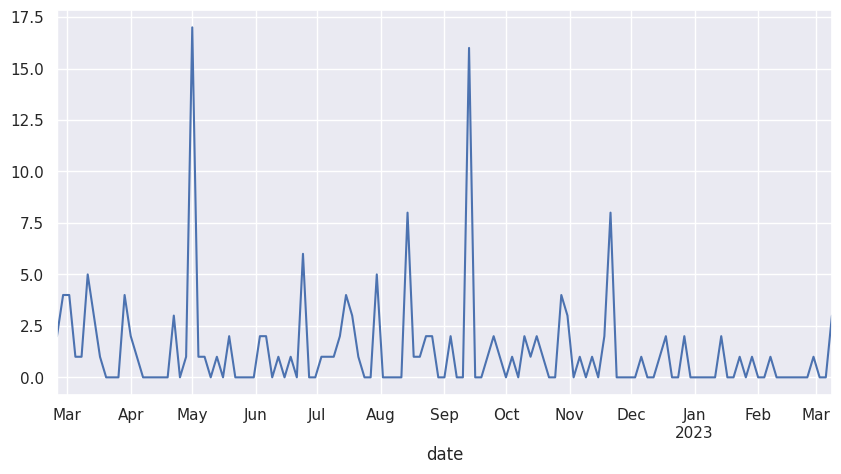

In [155]:
missiles['dummy'].resample(str(SAMPLE_FREQ) + 'd').sum().plot()

In [156]:
missiles['dummy'].to_csv('acled_missiles_dummy.csv')

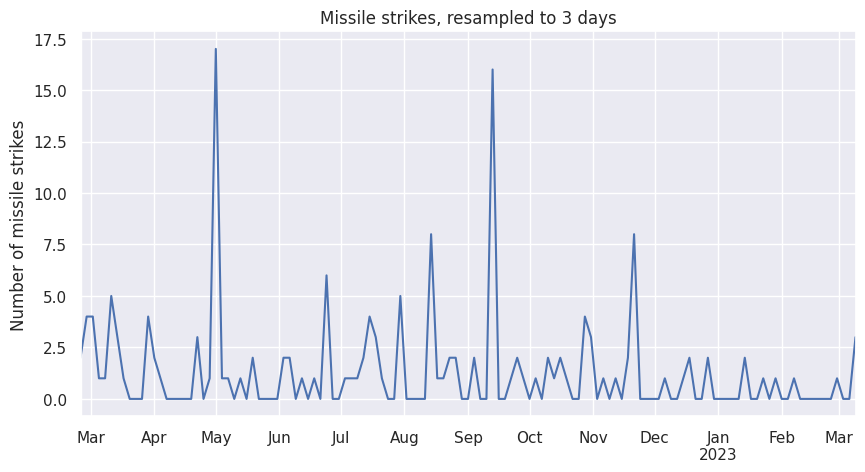

In [157]:
plt.figure()
plt.title(f'Missile strikes, resampled to {SAMPLE_FREQ} days')
missiles['dummy'].resample('3d').sum().plot(xlabel='', ylabel='Number of missile strikes')
plt.savefig('acled_missile_strikes.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missile_strikes.png', bbox_inches='tight', dpi=600)

In [158]:
strikes_comparison = pd.concat(
    [missiles['dummy'].resample('3d').sum(), strikes['dummy'].resample('3d').sum()],
    axis=1,
)
strikes_comparison.columns = ['missiles', 'strikes']
strikes_comparison = strikes_comparison.sort_index()

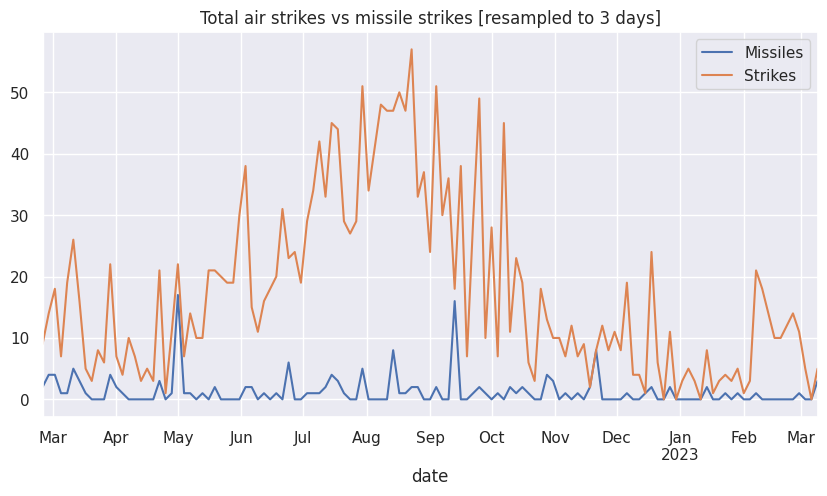

In [159]:
plt.figure()
plt.title(f'Total air strikes vs missile strikes [resampled to {SAMPLE_FREQ} days]')
#missiles['dummy'].resample('3d').sum().plot(xlabel='', ylabel='Number of strikes')
#strikes['dummy'].resample('3d').sum().plot(xlabel='')
ax = strikes_comparison['missiles'].plot()
strikes_comparison['strikes'].plot(ax=ax)
ax.legend(['Missiles', 'Strikes'])

plt.savefig('acled_air_vs_missile_strikes.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_air_vs_missile_strikes.png', bbox_inches='tight', dpi=600)

## Correlation missiles to total (air) strikes

In [160]:
strikes_comparison.corr().iloc[0, 1]

0.1788722721999166